# 모듈을 임포트합니다

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import (Activation,BatchNormalization,Concatenate,Dense,
                                     Embedding,Flatten,Input,Multiply,Reshape)
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Conv2D,Conv2DTranspose
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from keras.models import load_model
from keras.layers import Dropout
import os


# 모델을 구성합니다.

## 모델을 구성하기 위한 기초 변수를 설정합니다.

In [ ]:
img_rows = 28          # 이미지의 행 크기 (세로 크기)
img_cols = 28          # 이미지의 열 크기 (가로 크기)
channels = 1           # 이미지의 채널 수 (흑백 이미지이므로 채널 수는 1)

img_shape = (img_rows, img_cols, channels)   # 이미지의 전체 형태

z_dim = 100            # 생성자에 입력으로 사용될 잡음 벡터의 차원
num_classes = 10       # 레이블의 수 (MNIST 데이터셋의 숫자 클래스 수는 0~9로 총 10개)

## GAN만들기

> 이 코드는 일반적인 GAN의 아키텍쳐를 구현합니다.

### 생성자를 빌드합니다.
> 일반적인 GAN의 생성자입니다. 여기서 생성자는 블랙해커의 기능을 수행합니다.

In [ ]:
def build_generator(z_dim):
    """
    z_dim : 잡음백터
    """
    model = Sequential()

    # 첫 번째 Dense 층: 잡음 벡터를 7x7x256 크기로 변환합니다.
    # 여기서 256은 특성맵의 크키이다.
    # 여기서 7 x 7은 특성맵의 높이와 너비이다.
    model.add(Dense(256 * 7 * 7, input_dim=z_dim))
    model.add(Reshape((7, 7, 256)))  # 잡음 벡터를 7x7x256 크기의 텐서로 재구성합니다.

    # 첫 번째 Conv2DTranspose 층: 7x7x256 텐서를 14x14x128 텐서로 업샘플링합니다.
    model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))  # 출력 형태: (14, 14, 128)
    model.add(BatchNormalization())  # 배치 정규화를 통해 학습을 안정화합니다.
    model.add(LeakyReLU(alpha=0.01))  # LeakyReLU 활성화 함수를 사용합니다.

    # 두 번째 Conv2DTranspose 층: 크기를 변경하지 않고 특성 맵의 깊이를 64로 줄입니다.
    model.add(Conv2DTranspose(64, kernel_size=3, strides=1, padding='same'))  # 출력 형태: (14, 14, 64)
    model.add(BatchNormalization())  # 배치 정규화를 통해 학습을 안정화합니다.
    model.add(LeakyReLU(alpha=0.01))  # LeakyReLU 활성화 함수를 사용합니다.

    # 세 번째 Conv2DTranspose 층: 14x14x64 텐서를 28x28x1 텐서로 업샘플링하며 출력 이미지를 생성합니다.
    model.add(Conv2DTranspose(1, kernel_size=3, strides=2, padding='same'))  # 출력 형태: (28, 28, 1)
    model.add(Activation('tanh'))  # tanh 활성화 함수를 통해 출력 값이 -1과 1 사이가 되도록 합니다.

    return model  # 생성된 생성자 모델을 반환합니다.

### 판별자를 빌드합니다.
> 일반적인 GAN의 판별자 입니다. 여기서 판별자는 화이트해커의 기능을 수행합니다.

In [ ]:
def build_discriminator(img_shape):

  model=Sequential()

  model.add( # (28,28,2) 에서 (14,14,64) 텐서로 바꾸는 합성곱 층
            Conv2D(64,kernel_size=3,strides=2,input_shape=(img_shape[0],img_shape[1],img_shape[2] +1),
                   padding='same'))
  model.add(LeakyReLU(alpha=0.01))

  model.add( # (14,14,64) 에서 (7,7,64) 텐서로 바꾸는 합성곱 층
            Conv2D(64,kernel_size=3,strides=2,padding='same'))
  model.add(LeakyReLU(alpha=0.01))

  model.add( # (7,7,64) 에서 (3,3,128) 텐서로 바꾸는 합성곱 층
            Conv2D(128,kernel_size=3,strides=2,padding='same'))
  model.add(LeakyReLU(alpha=0.01))

  model.add(Flatten())
  model.add(Dense(1,activation='sigmoid'))

  return model

## 레이블을 구현하기 위해 GAN을 변형하여 구현합니다.
> 기존의 모델은 랜덤잡음 위에서 변형하여 랜덤한 이미지를 리턴하였습니다.
> 하지만, 모델을 잡음과 클래스를 모두 인풋하는 방식으로 GAN을 변형하여 비밀번호 이미지를 생성하는 GAN을 구현하겠습니다.

### 변형한 GAN의 생성자를 구현합니다.

In [ ]:
def build_cgan_generator(z_dim):
  """이 함수는 변형한 GAN의 생성기 부분을 구현한 것입니다. """
  # 입력 레이블
  z=Input(shape=(z_dim,))  # 랜덤 잡음 벡터 z
  label=Input(shape=(1,),dtype='int32') # 조건 레이블 정수 0~9까지 생성자가 만들 숫자

  # 레이블 임베딩
  # 레이블을 z_dim 크기 밀집 벡터로 변환하고(batch_size,1,z_dim) 크기 3D 텐서를 만든다.
  label_embedding=Embedding(num_classes,z_dim,input_length=1)(label)
  # 임베딩된 3D 텐서를 펼쳐서 (batch_size,z_dim) 크기 2D 텐서로 바꾼다 이는 임베딩 결과와 잡음 벡터를 같은 차원으로 만들기 위해 필요합니다.
  label_embedding=Flatten()(label_embedding)
  # 잡음 백터와 레이블 임베딩을 요소별로 곱하여 잡음 백터에 레이블 정보를 포함하도록 합니다.
  joined_representation=Multiply()([z,label_embedding])

  generator=build_generator(z_dim) # 이전에 정의한 generator을 사용해 모델을 구축합니다.
  conditioned_img=generator(joined_representation)  # 주어진 레이블에 대한 이미지 생성

  return Model([z,label],conditioned_img) # 최종적으로 이 함수는 잡음 벡터와 레이블을 입력으로 받아 조건화된 이미지를 출력하는 Keras 모델을 반환합니다.

### 변형한 GAN의 판별자를 구현합니다.

In [ ]:
def build_cgan_discriminator(img_shape):
  img=Input(shape=img_shape)

  label=Input(shape=(1,),dtype='int32') # 입력 이미지의 레이블

  # 레이블 임베딩: 레이블을 z_dim 크기의 밀집 벡터로 변환하고 (batch_size,1,28x28x1) 크기의 3D 텐서를 만든다.
  label_embedding=Embedding(num_classes, np.prod(img_shape),input_length=1)(label)
  # 임베딩된 3D 텐서를 펼쳐서 (batch_size,28x28x1) 크기의 2D 텐서를 만든다
  label_embedding=Flatten()(label_embedding)
  # 레이블 임베딩 크기를 입력 이미지 차원과 동일하게 만든다
  label_embedding=Reshape(img_shape)(label_embedding)
  # 이미지와 레이블 임베딩을 연결한다
  concatenated=Concatenate(axis=-1)([img,label_embedding])

  discriminator=build_discriminator(img_shape)
  classification=discriminator(concatenated)  # 이미지-레이블 쌍을 분류한다

  return Model([img,label],classification)

In [ ]:
def build_cgan(generator,discriminator):
  z=Input(shape=(z_dim,))  # 랜덤 잡음 벡터 z
  label=Input(shape=(1,))  # 이미지 레이블
  img=generator([z,label]) # 레이블에 맞는 이미지 생성하기

  classification=discriminator([img,label])

  model=Model([z,label],classification)

  return model

In [ ]:
discriminator=build_cgan_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy',optimizer=Adam(learning_rate=0.00001),
                      metrics=['accuracy'])

generator=build_cgan_generator(z_dim)
discriminator.trainable=False

cgan=build_cgan(generator,discriminator)
cgan.compile(loss='binary_crossentropy',optimizer=Adam())

### 모델확인

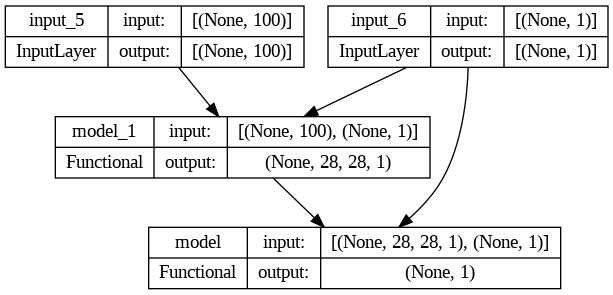

In [ ]:
plot_model(cgan,show_shapes=True)

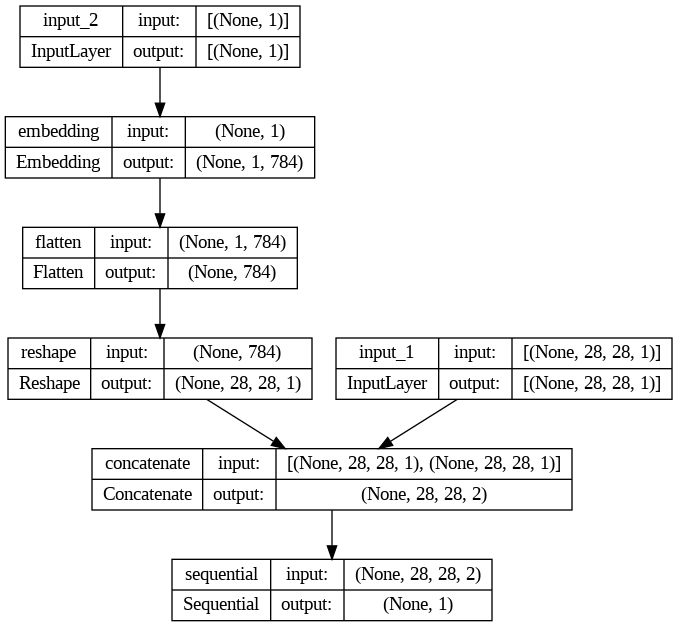

In [ ]:
plot_model(discriminator,show_shapes=True)

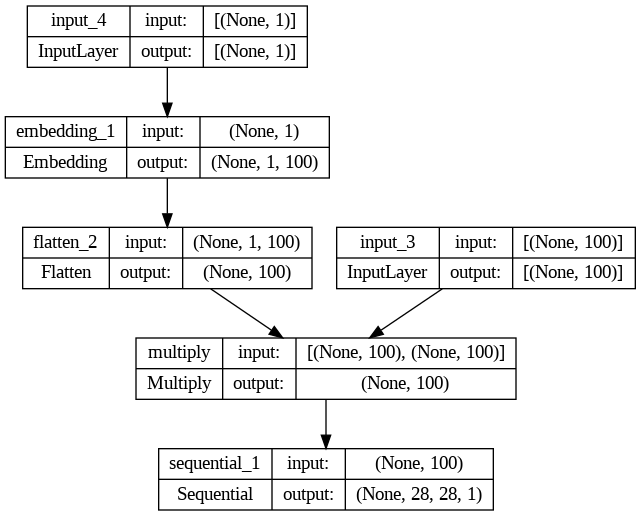

In [ ]:
plot_model(generator, show_shapes=True)

# 모델학습

In [ ]:
accuracies = []
losses = []


def train(iterations, batch_size, sample_interval):

    # MNIST 데이터셋을 로드합니다.
    (X_train, y_train), (_, _) = mnist.load_data()

    # [0, 255] 사이 흑백 픽셀 값을 [–1, 1]로 스케일 변환합니다.
    X_train = X_train / 127.5 - 1.
    X_train = np.expand_dims(X_train, axis=3)

    # 진짜 이미지의 레이블: 모두 1
    real = np.ones((batch_size, 1))

    # 가짜 이미지의 레이블: 모두 0
    fake = np.zeros((batch_size, 1))

    for iteration in range(iterations):

        # -------------------------
        #  판별자를 훈련합니다.
        # -------------------------

        # 진짜 이미지와 레이블로 이루어진 랜덤한 배치를 얻습니다.
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs, labels = X_train[idx], y_train[idx]

        # 가짜 이미지 배치를 생성합니다.
        z = np.random.normal(0, 1, (batch_size, z_dim))
        gen_imgs = generator.predict([z, labels])

        # 판별자를 훈련합니다.
        d_loss_real = discriminator.train_on_batch([imgs, labels], real)
        d_loss_fake = discriminator.train_on_batch([gen_imgs, labels], fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  생성자를 훈련합니다.
        # ---------------------

        # 잡음 벡터의 배치를 생성합니다.
        z = np.random.normal(0, 1, (batch_size, z_dim))

        # 랜덤한 레이블의 배치를 얻습니다.
        labels = np.random.randint(0, num_classes, batch_size).reshape(-1, 1)

        # 생성자를 훈련합니다.
        g_loss = cgan.train_on_batch([z, labels], real)


        if (iteration + 1) % sample_interval == 0:

            # 훈련 과정을 출력합니다.
            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                  (iteration + 1, d_loss[0], 100 * d_loss[1], g_loss))

            # 훈련이 끝난 후 그래프를 그리기 위해 손실과 정확도를 저장합니다.
            losses.append((d_loss[0], g_loss))
            accuracies.append(100 * d_loss[1])

            # 생성한 이미지 샘플을 출력합니다.
            sample_images()

## 이미지 생성

In [ ]:
def sample_images(image_grid_rows=2, image_grid_columns=5):

    # 랜덤한 잡음을 샘플링합니다.
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

    # 0–9 사이의 이미지 레이블을 만듭니다.
    labels = np.arange(0, 10).reshape(-1, 1)

    # 랜덤한 잡음에서 이미지를 생성합니다.
    gen_imgs = generator.predict([z, labels])

    # 이미지 픽셀 값을 [0, 1] 사이로 스케일을 변환합니다.
    gen_imgs = 0.5 * gen_imgs + 0.5

    # 이미지 그리드를 설정합니다.
    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(10, 4),
                            sharey=True,
                            sharex=True)

    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            # 이미지 그리드를 출력합니다.
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            axs[i, j].set_title("Digit: %d" % labels[cnt])
            cnt += 1

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
1/1 [==============================] - 0s 36ms/step
16000 [D loss: 0.576017, acc.: 90.62%] [G loss: 0.753904]
1/1 [==============================] - 0s 21ms/step
17000 [D loss: 0.575697, acc.: 85.94%] [G loss: 0.806001]
1/1 [==============================] - 0s 21ms/step
18000 [D loss: 0.731820, acc.: 45.31%] [G loss: 0.633463]
1/1 [==============================] - 0s 18ms/step
19000 [D loss: 0.745771, acc.: 21.88%] [G loss: 0.628390]
1/1 [==============================] - 0s 28ms/step
20000 [D loss: 0.754371, acc.: 7.81%] [G loss: 0.648954]
1/1 [==============================] - 0s 31ms/step


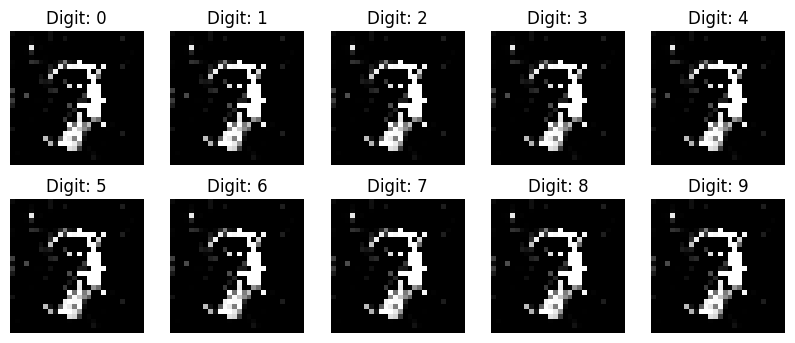

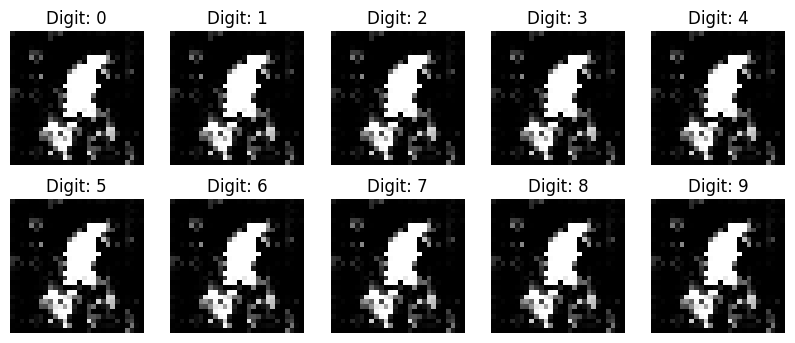

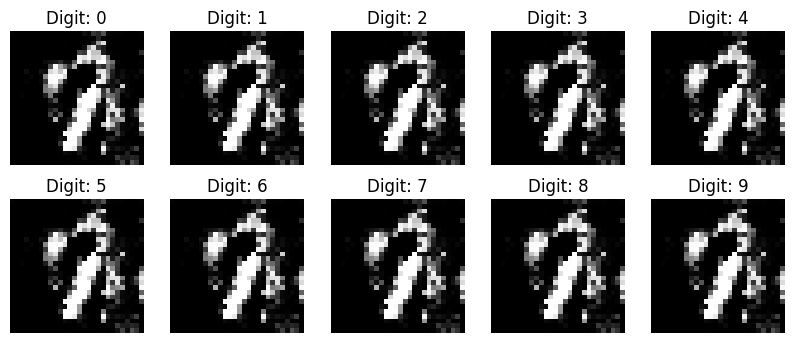

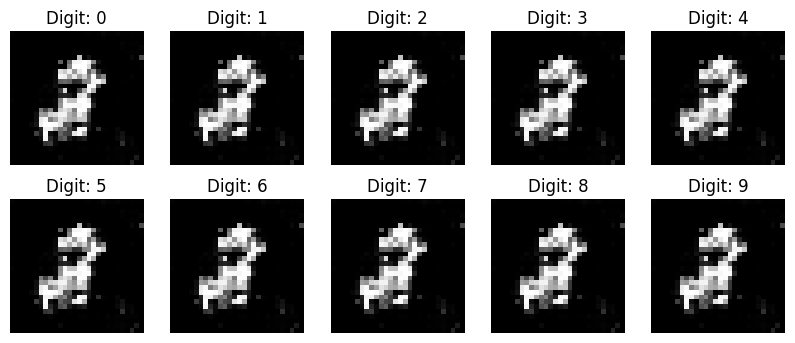

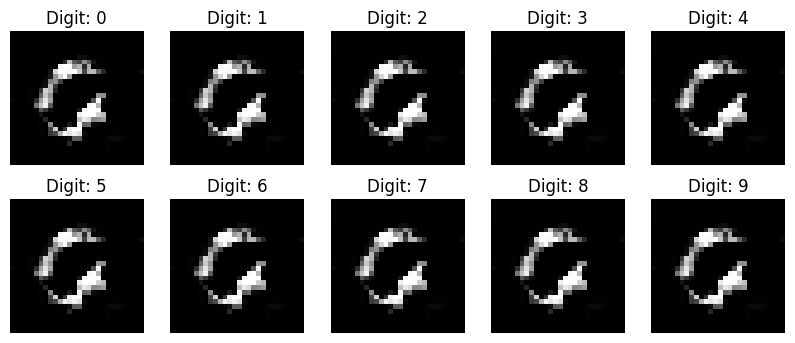

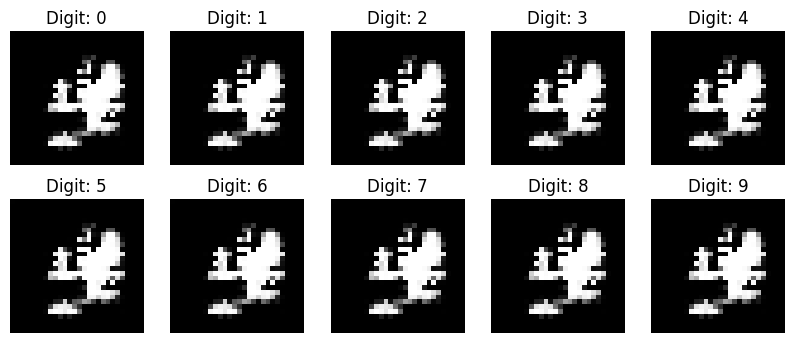

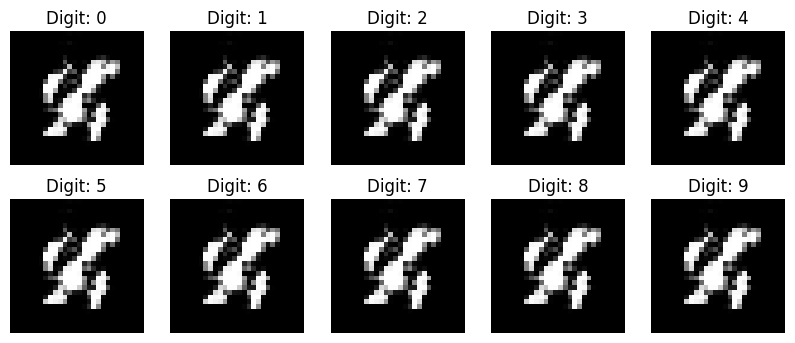

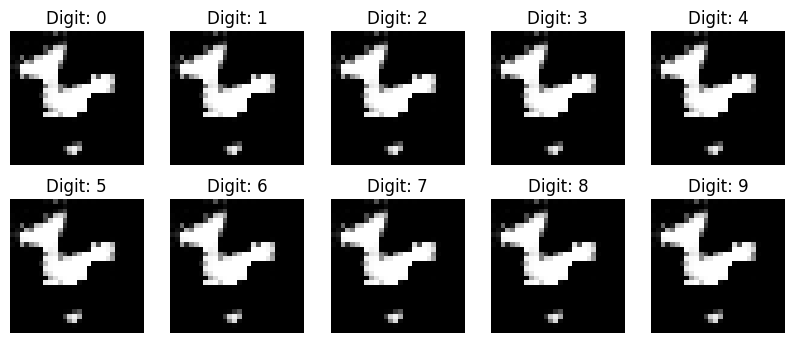

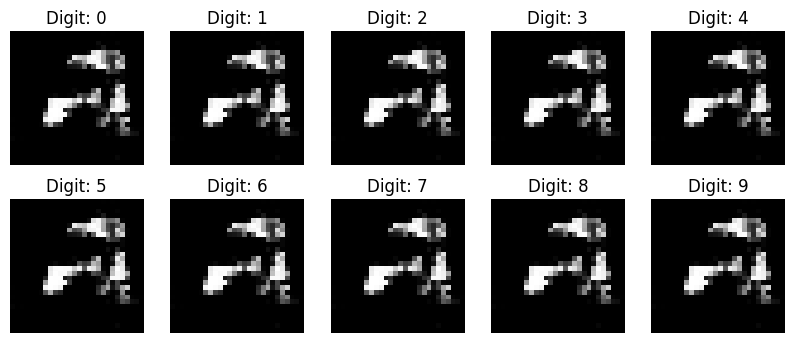

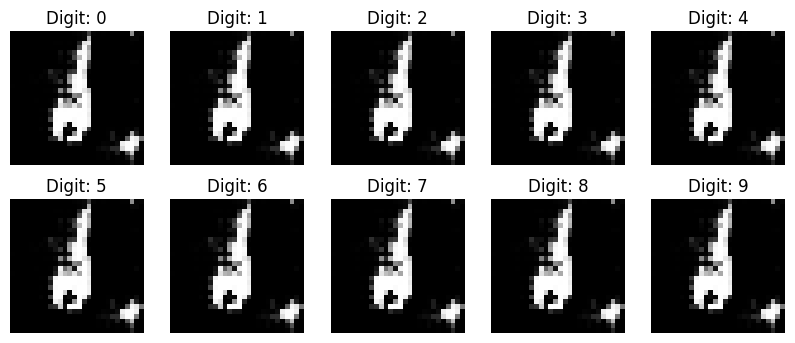

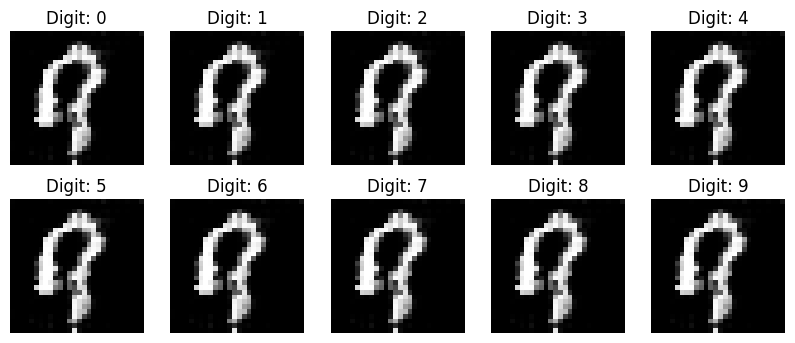

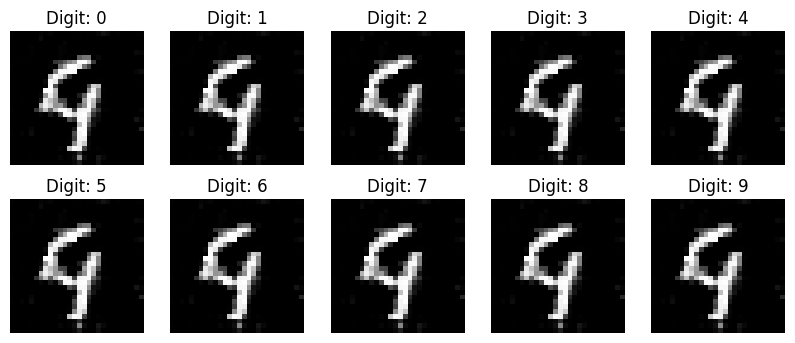

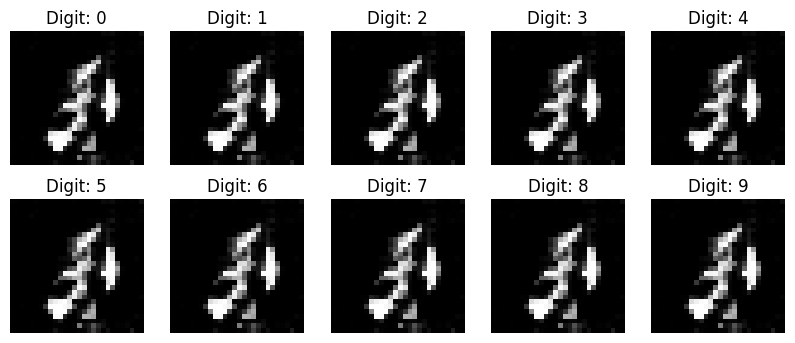

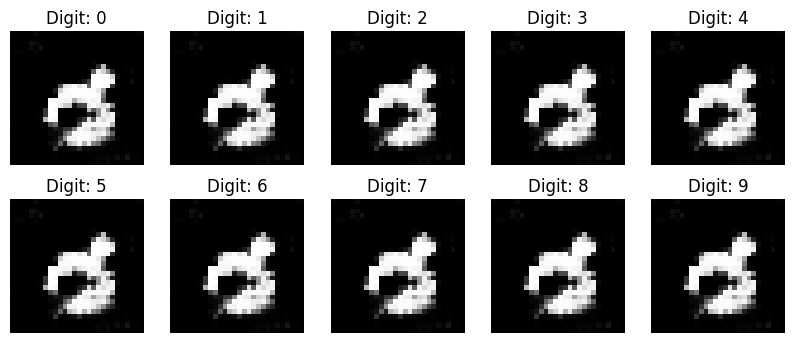

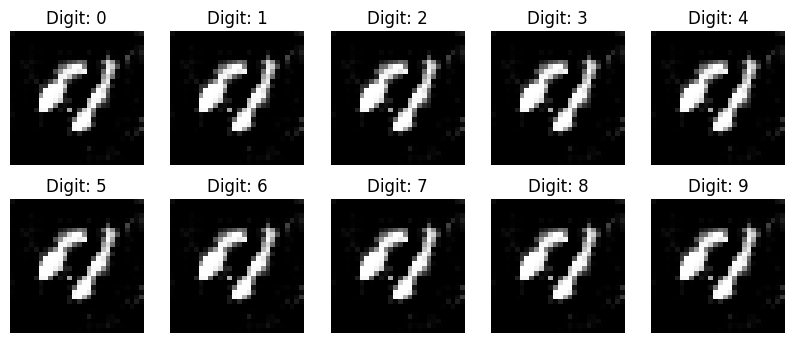

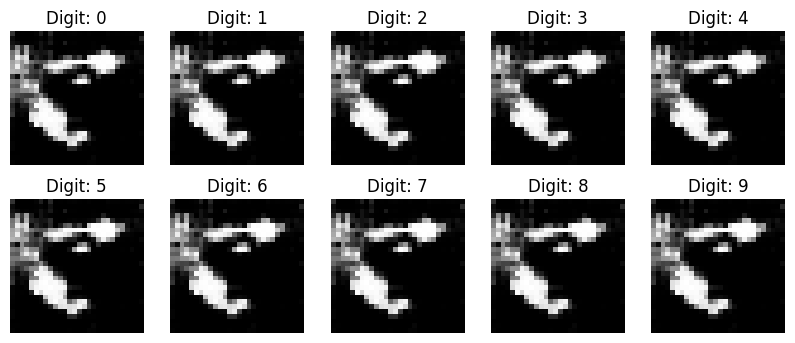

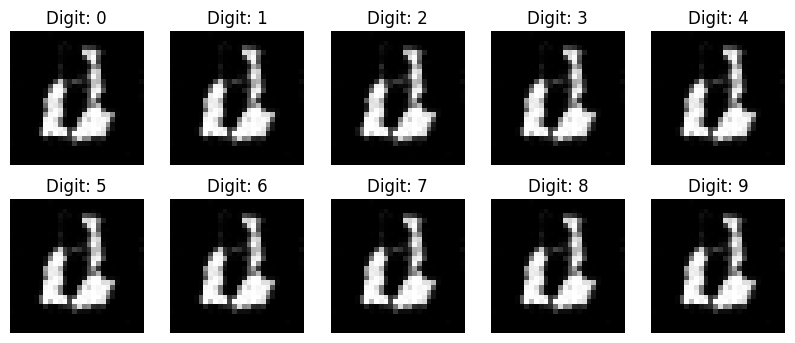

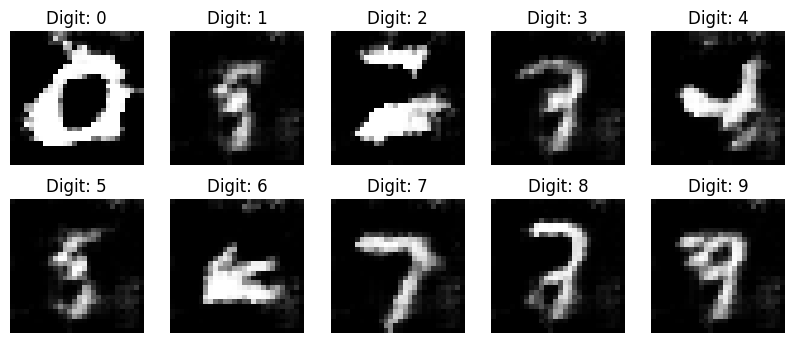

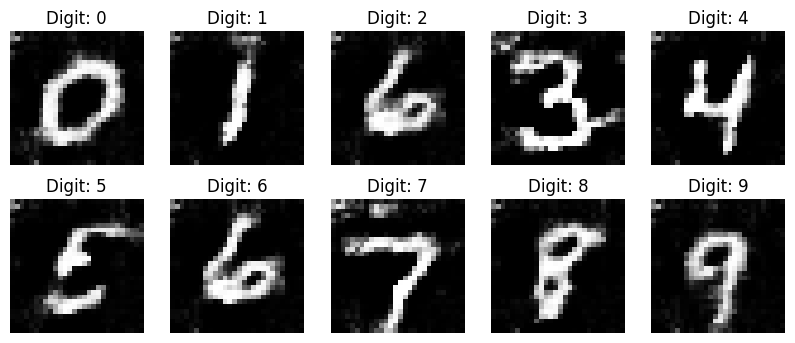

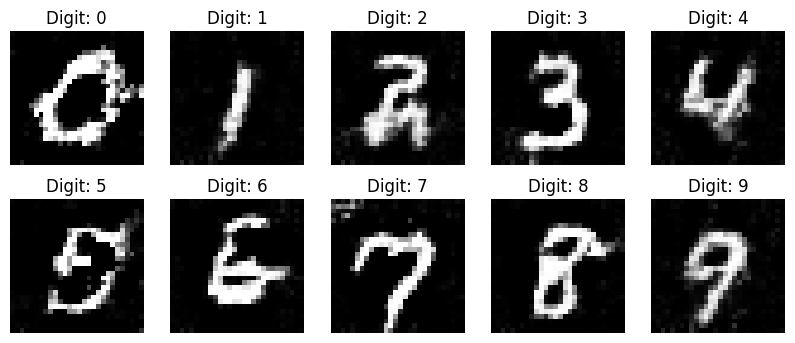

In [ ]:
iterations=20000
batch_size=32
sample_interval=1000
with tf.device("/GPU:0"):
    train(iterations,batch_size,sample_interval)

## 정확도확인

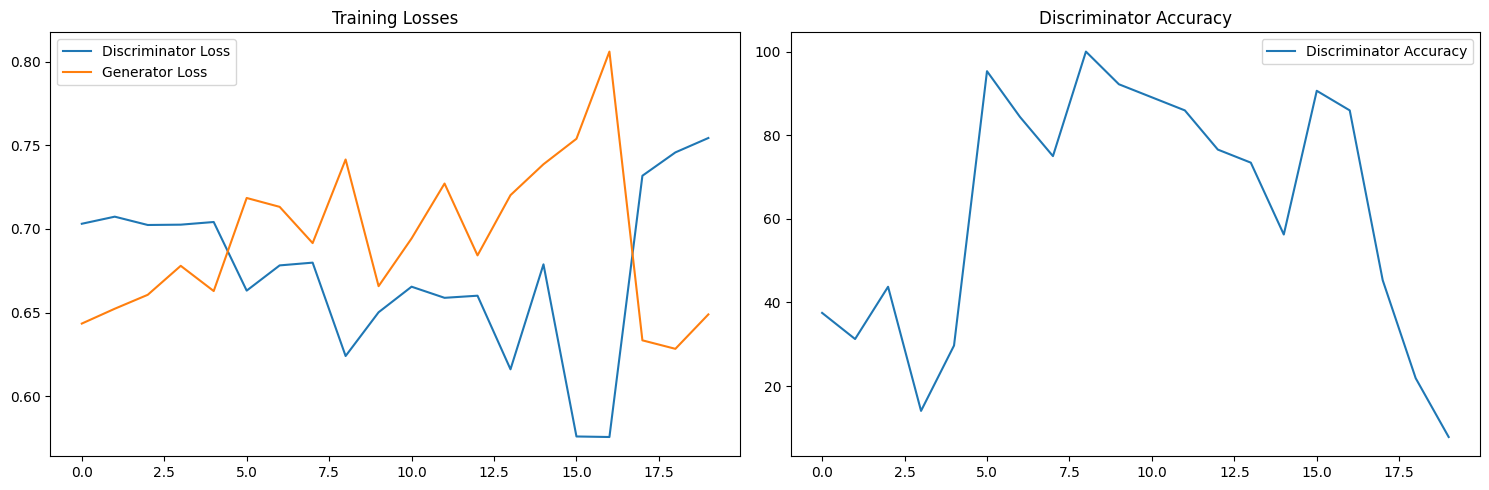

In [ ]:
def plot_losses(losses, accuracies):
    """
    손실과 정확도를 그래프로 그립니다.
    """
    d_losses = [v[0] for v in losses]
    g_losses = [v[1] for v in losses]

    plt.figure(figsize=(15, 5))

    # Discriminator and Generator Loss
    plt.subplot(1, 2, 1)
    plt.plot(d_losses, label="Discriminator Loss")
    plt.plot(g_losses, label="Generator Loss")
    plt.title("Training Losses")
    plt.legend()

    # Discriminator Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(accuracies, label="Discriminator Accuracy")
    plt.title("Discriminator Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

# 훈련이 끝나면 아래 함수를 호출해서 그래프를 그릴 수 있습니다.
plot_losses(losses, accuracies)


In [ ]:
# 생성자와 판별자 모델을 저장합니다.
generator.save('generator_model.h5')
discriminator.save('discriminator_model.h5')

1/1 [==============================] - 0s 26ms/step


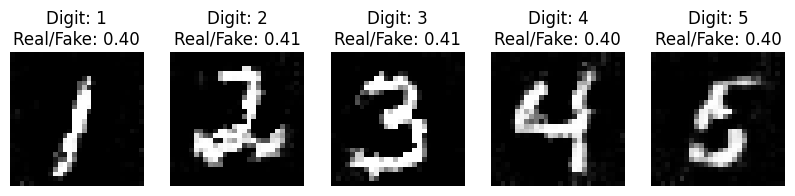

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def draw_images(generator, discriminator, digits_list):
    z_dim = 100  # 여기서는 z_dim을 100으로 가정합니다.

    # 샘플링할 이미지의 수를 계산합니다.
    num_images = len(digits_list)

    # 랜덤한 잡음을 샘플링합니다.
    z = np.random.normal(0, 1, (num_images, z_dim))

    # 지정된 숫자로 레이블을 생성합니다.
    labels_to_generate = np.array(digits_list).reshape(-1, 1)

    # 랜덤한 잡음에서 이미지를 생성합니다.
    gen_imgs = generator.predict([z, labels_to_generate])

    # 이미지 픽셀 값을 [0, 1] 사이로 스케일을 변환합니다.
    gen_imgs = 0.5 * gen_imgs + 0.5

    # 이미지 그리드를 설정합니다.
    fig, axs = plt.subplots(1, num_images, figsize=(10, 2))

    for i in range(num_images):
        axs[i].imshow(gen_imgs[i, :, :, 0], cmap='gray')
        axs[i].axis('off')

        # 판별자를 사용하여 이미지가 진짜인지 가짜인지 판별합니다.
        real_or_fake = discriminator.predict([gen_imgs[i:i+1], labels_to_generate[i:i+1]])
        title_str = "Digit: %d\nReal/Fake: %.2f" % (labels_to_generate[i], real_or_fake[0])
        axs[i].set_title(title_str)

    plt.show()


draw_images(generator, discriminator, [1, 2, 3,4,5])
